In [41]:
# Cell 1: Importing Libraries and Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# Load the dataset
aqi = pd.read_csv("data.csv", encoding="ISO-8859-1", parse_dates=['date'])
aqi.head()


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [42]:
# Cell 2: Checking for Missing Values
sns.set(style="ticks", rc={'figure.figsize':(20,15)})

# Suppressing warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Checking for missing values and dataset info
print(aqi.isnull().sum())
print(aqi.shape)
aqi.info()


stn_code                       144077
sampling_date                       3
state                               0
location                            3
agency                         149481
type                             5393
so2                             34646
no2                             16233
rspm                            40222
spm                            237387
location_monitoring_station     27491
pm2_5                          426428
date                                7
dtype: int64
(435742, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   stn_code                     291665 non-null  object        
 1   sampling_date                435739 non-null  object        
 2   state                        435742 non-null  object        
 3   location                     43573

In [43]:
# Cell 3: Data Cleaning - Dropping Unnecessary Columns and Handling Missing Dates
# Dropping columns that do not add useful information
aqi.drop(['stn_code', 'agency', 'sampling_date', 'location_monitoring_station'], axis=1, inplace=True)
# Dropping rows where 'date' is missing
aqi.dropna(subset=['date'], inplace=True)

# Standardizing state names and type categories
aqi['state'].replace({'Uttaranchal': 'Uttarakhand'}, inplace=True)
aqi['state'][aqi['location'] == "Jamshedpur"] = aqi['state'][aqi['location'] == "Jamshedpur"].replace({'Bihar': 'Jharkhand'})

# Consolidating 'type' categories
types = {
    "Residential": "R",
    "Residential and others": "RO",
    "Residential, Rural and other Areas": "RRO",
    "Industrial Area": "I",
    "Industrial Areas": "I",
    "Industrial": "I",
    "Sensitive Area": "S",
    "Sensitive Areas": "S",
    "Sensitive": "S",
    np.nan: "RRO"
}
aqi['type'] = aqi['type'].replace(types)
aqi.head()


,state,location,type,so2,no2,rspm,spm,pm2_5,date
0,Andhra Pradesh,Hyderabad,RRO,4.8,17.4,NaN,NaN,NaN,1990-02-01
1,Andhra Pradesh,Hyderabad,I,3.1,7.0,NaN,NaN,NaN,1990-02-01
2,Andhra Pradesh,Hyderabad,RRO,6.2,28.5,NaN,NaN,NaN,1990-02-01
3,Andhra Pradesh,Hyderabad,RRO,6.3,14.7,NaN,NaN,NaN,1990-03-01
4,Andhra Pradesh,Hyderabad,I,4.7,7.5,NaN,NaN,NaN,1990-03-01


In [44]:
# Cell 4: Filling Missing Values in Pollutant Columns
# Selecting pollutant columns to fill missing values
VALUE_COLS = ['so2', 'no2', 'rspm', 'spm', 'pm2_5']

# Using SimpleImputer to fill missing pollutant values with column means
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
aqi[VALUE_COLS] = imputer.fit_transform(aqi[VALUE_COLS])

# Verifying there are no remaining null values
print(aqi.isnull().sum())
aqi.tail()


state       0
location    0
type        0
so2         0
no2         0
rspm        0
spm         0
pm2_5       0
date        0
dtype: int64


,state,location,type,so2,no2,rspm,spm,pm2_5,date
435734,West Bengal,ULUBERIA,RIRUO,20.0,44.0,148.0,220.78348,40.791467,2015-12-15
435735,West Bengal,ULUBERIA,RIRUO,17.0,44.0,131.0,220.78348,40.791467,2015-12-18
435736,West Bengal,ULUBERIA,RIRUO,18.0,45.0,140.0,220.78348,40.791467,2015-12-21
435737,West Bengal,ULUBERIA,RIRUO,22.0,50.0,143.0,220.78348,40.791467,2015-12-24
435738,West Bengal,ULUBERIA,RIRUO,20.0,46.0,171.0,220.78348,40.791467,2015-12-29


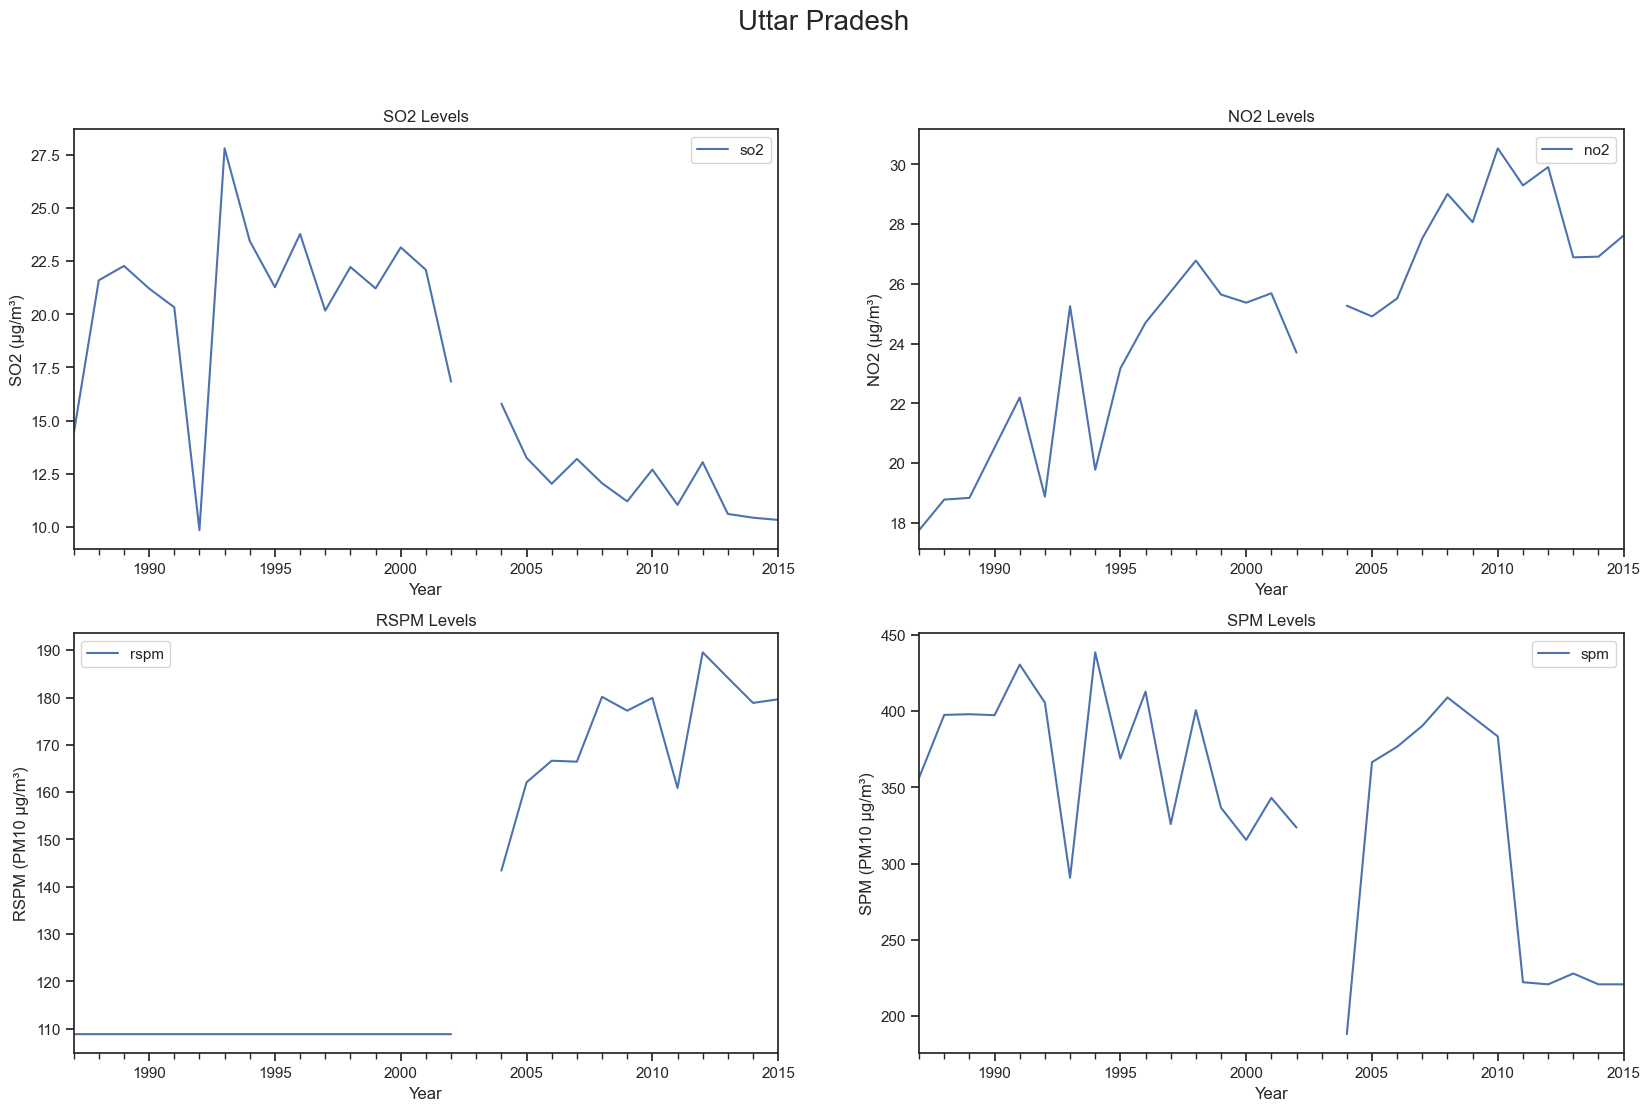

In [45]:
# Cell 5: Visualizing Pollutant Levels by Year for a Specific State
def plot_for_state(state_name):
    fig, ax = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle(state_name, size=20)
    state_data = aqi[aqi['state'] == state_name].set_index('date')[VALUE_COLS].resample('Y').mean()

    state_data['so2'].plot(legend=True, ax=ax[0][0], title="SO2 Levels")
    ax[0][0].set_ylabel("SO2 (µg/m³)")
    ax[0][0].set_xlabel("Year")

    state_data['no2'].plot(legend=True, ax=ax[0][1], title="NO2 Levels")
    ax[0][1].set_ylabel("NO2 (µg/m³)")
    ax[0][1].set_xlabel("Year")

    state_data['rspm'].plot(legend=True, ax=ax[1][0], title="RSPM Levels")
    ax[1][0].set_ylabel("RSPM (PM10 µg/m³)")
    ax[1][0].set_xlabel("Year")

    state_data['spm'].plot(legend=True, ax=ax[1][1], title="SPM Levels")
    ax[1][1].set_ylabel("SPM (PM10 µg/m³)")
    ax[1][1].set_xlabel("Year")

plot_for_state("Uttar Pradesh")


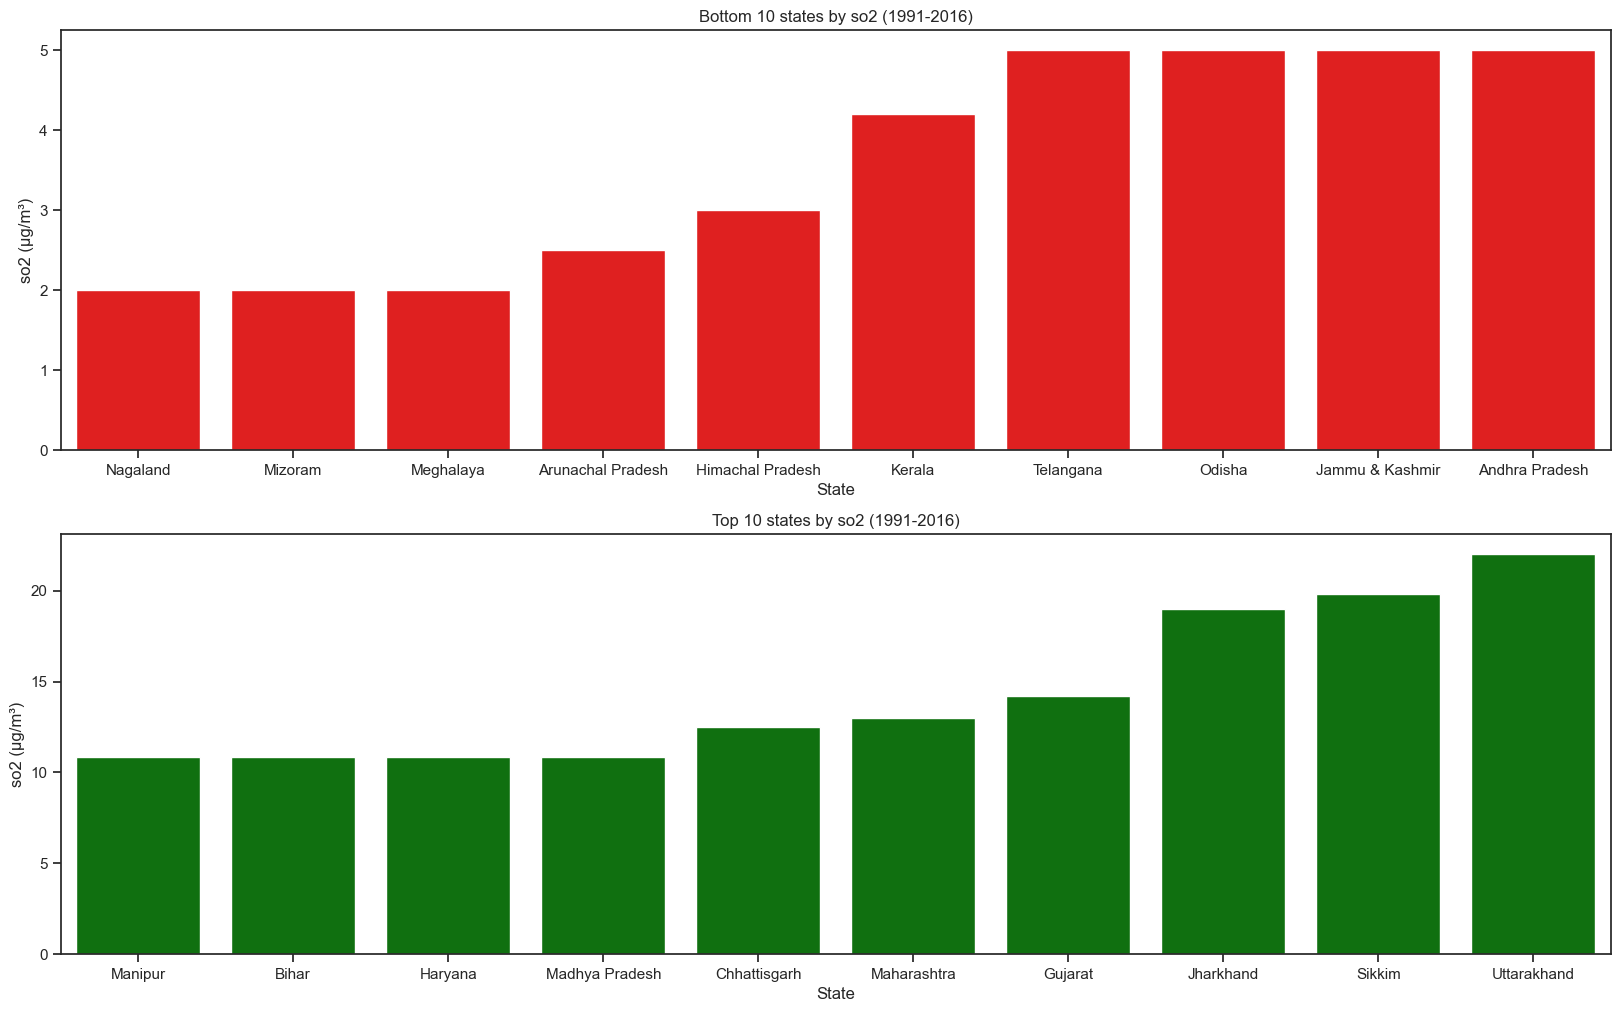

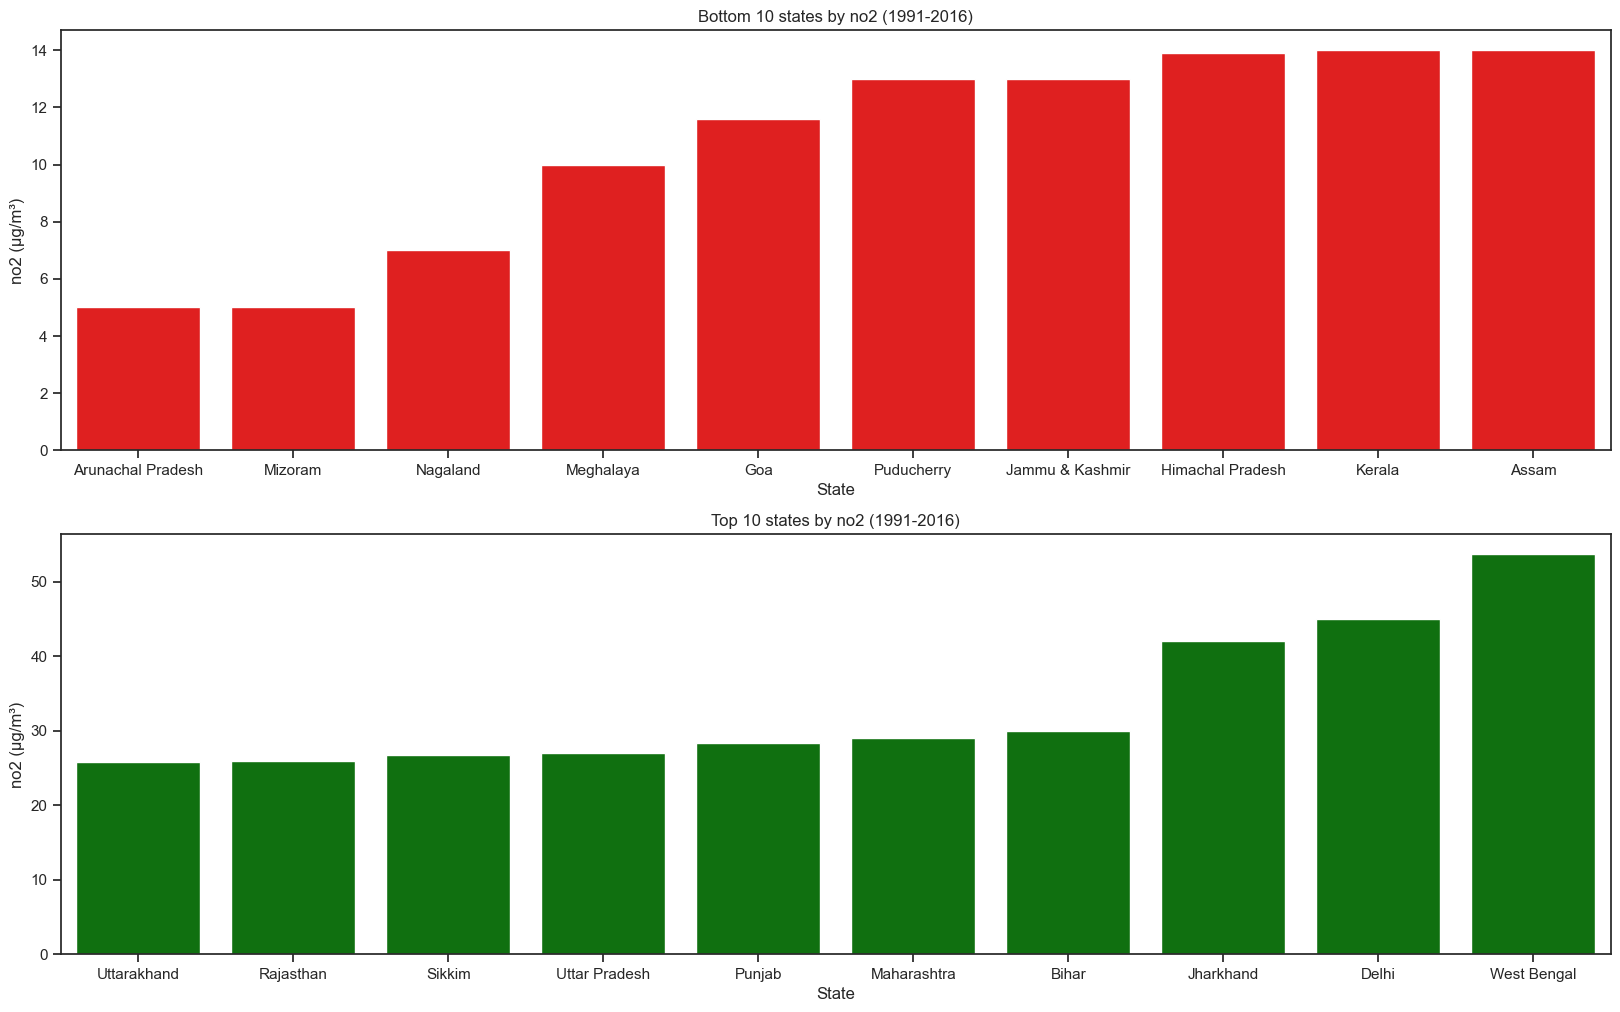

In [46]:
# Cell 6: Top and Bottom 10 States for Pollutants
def top_and_bottom_10_states(indicator="so2"):
    fig, ax = plt.subplots(2, 1, figsize=(20, 12))
    state_medians = aqi.groupby('state')[indicator].median().reset_index().sort_values(by=indicator)

    sns.barplot(x='state', y=indicator, data=state_medians[:10], ax=ax[0], color="red")
    ax[0].set_title(f"Bottom 10 states by {indicator} (1991-2016)")
    ax[0].set_ylabel(f"{indicator} (µg/m³)")
    ax[0].set_xlabel("State")

    sns.barplot(x='state', y=indicator, data=state_medians[-10:], ax=ax[1], color="green")
    ax[1].set_title(f"Top 10 states by {indicator} (1991-2016)")
    ax[1].set_ylabel(f"{indicator} (µg/m³)")
    ax[1].set_xlabel("State")

top_and_bottom_10_states("so2")
top_and_bottom_10_states("no2")

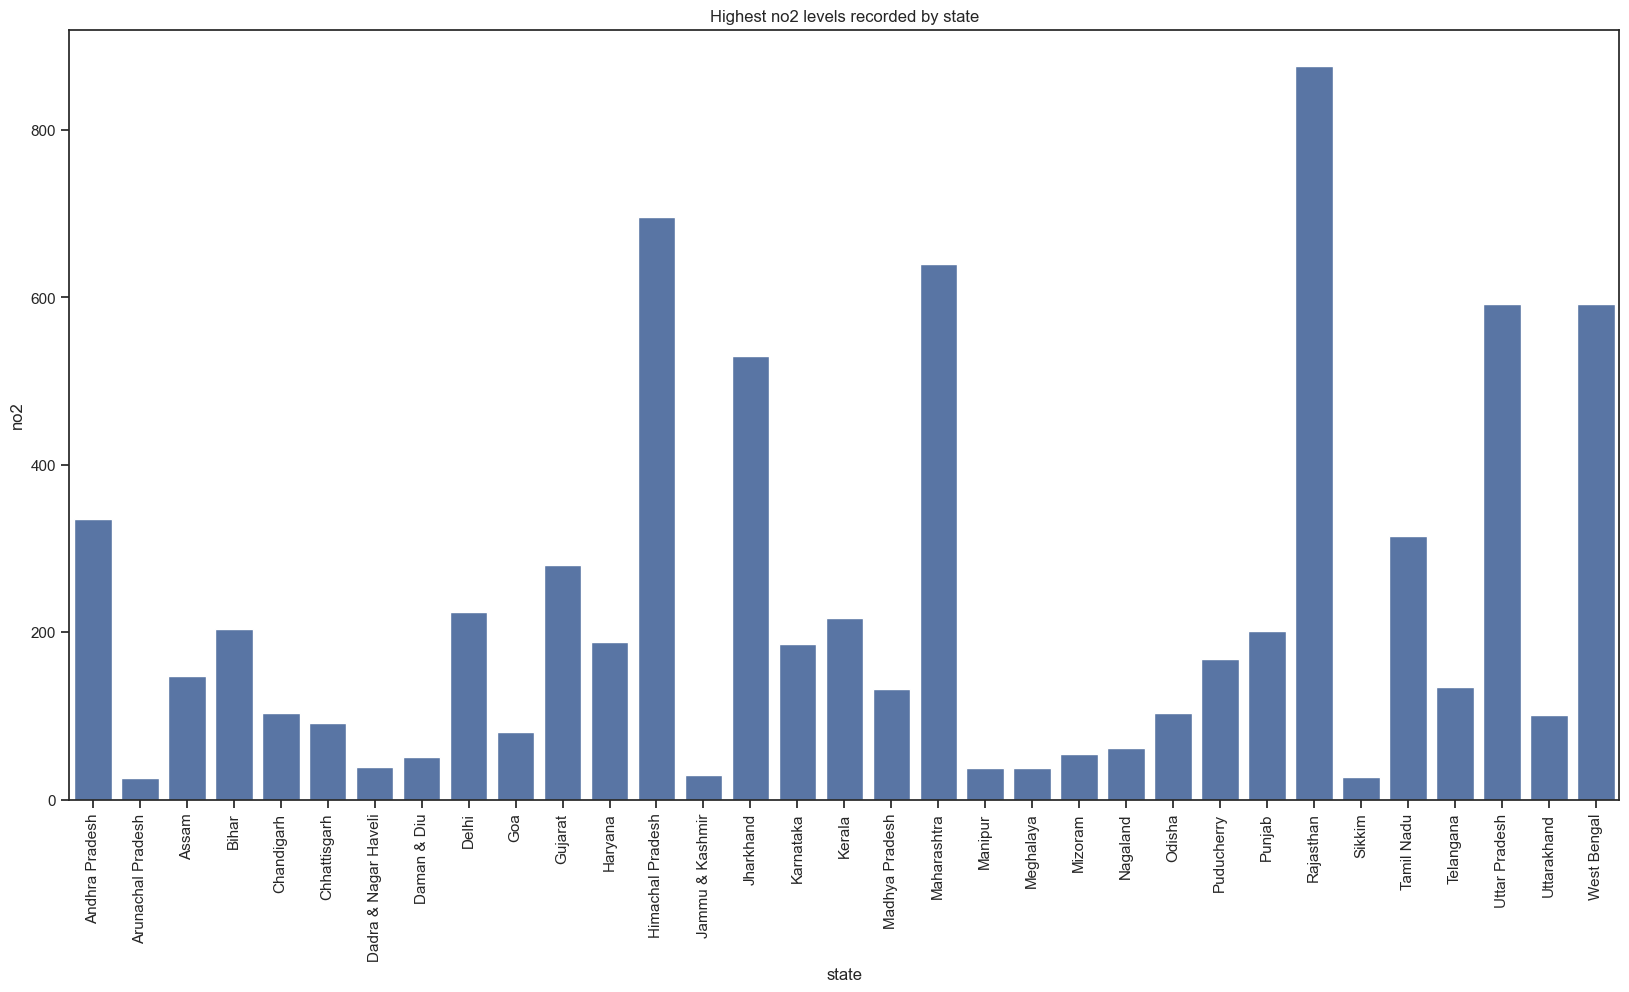

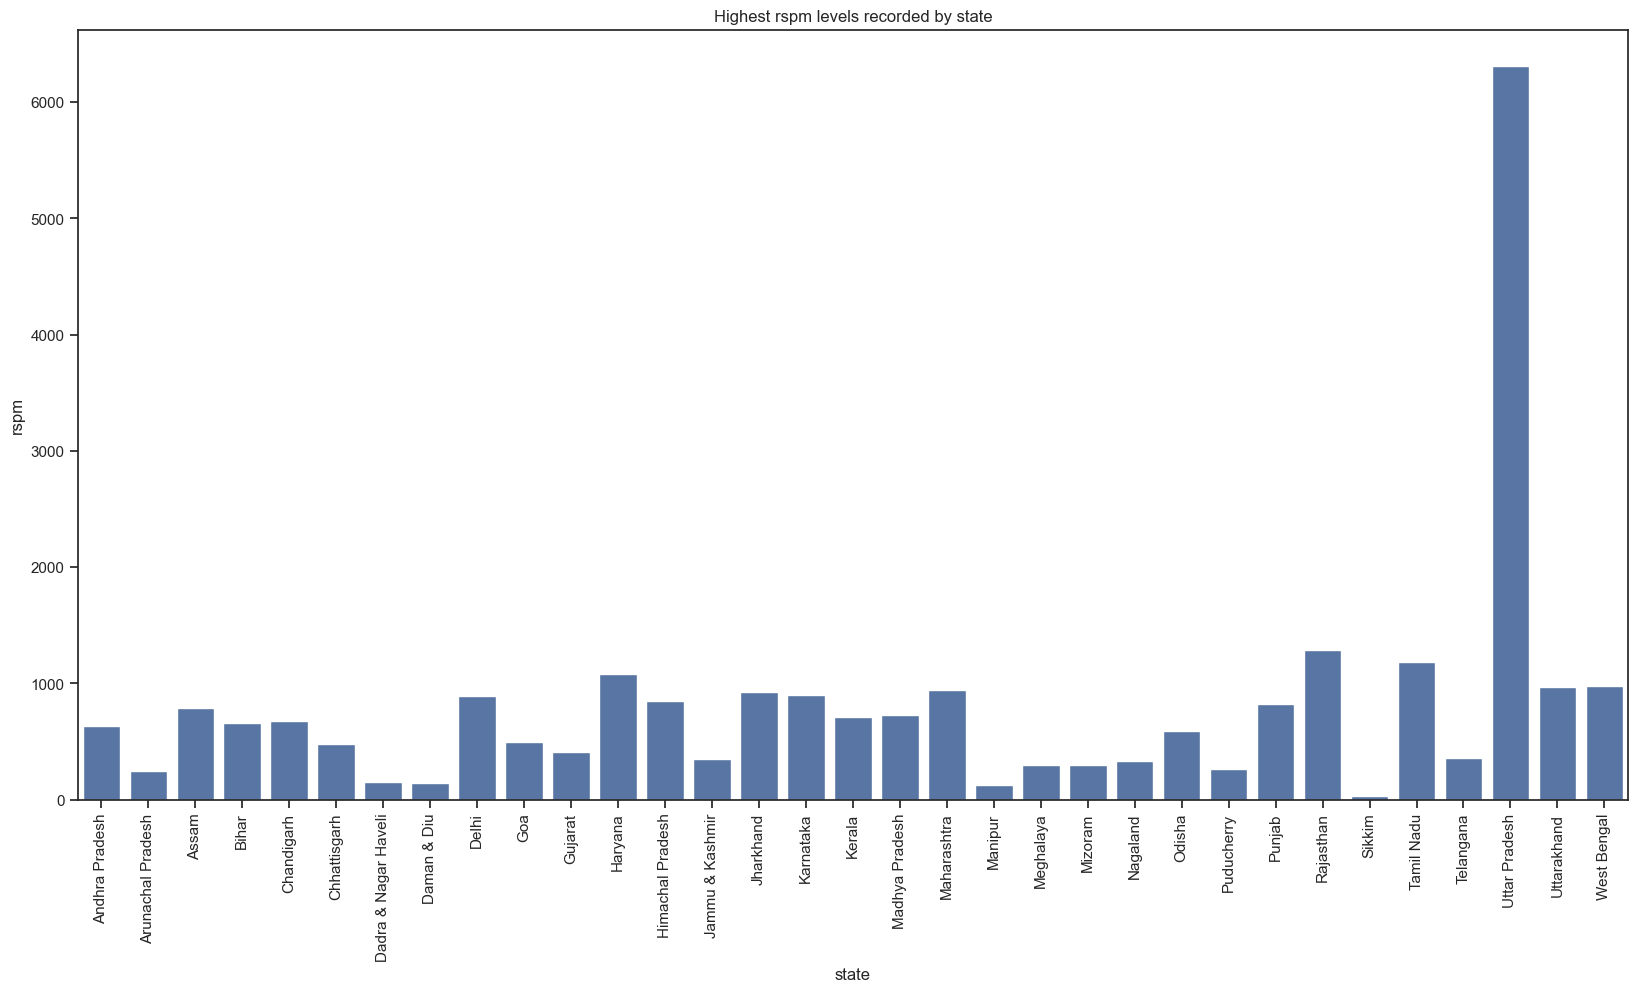

In [47]:
# Cell 7: Highest Levels Recorded for Each Pollutant
def highest_levels_recorded(indicator="so2"):
    plt.figure(figsize=(20, 10))
    highest_levels = aqi.groupby('state')[indicator].max().reset_index()
    sns.barplot(x='state', y=indicator, data=highest_levels)
    plt.title(f"Highest {indicator} levels recorded by state")
    plt.xticks(rotation=90)

highest_levels_recorded("no2")
highest_levels_recorded("rspm")


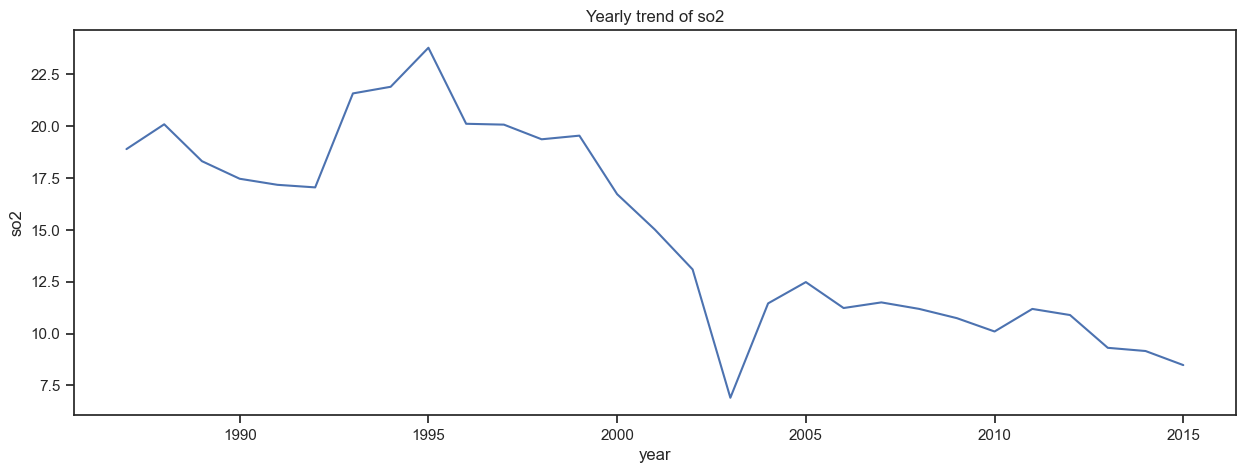

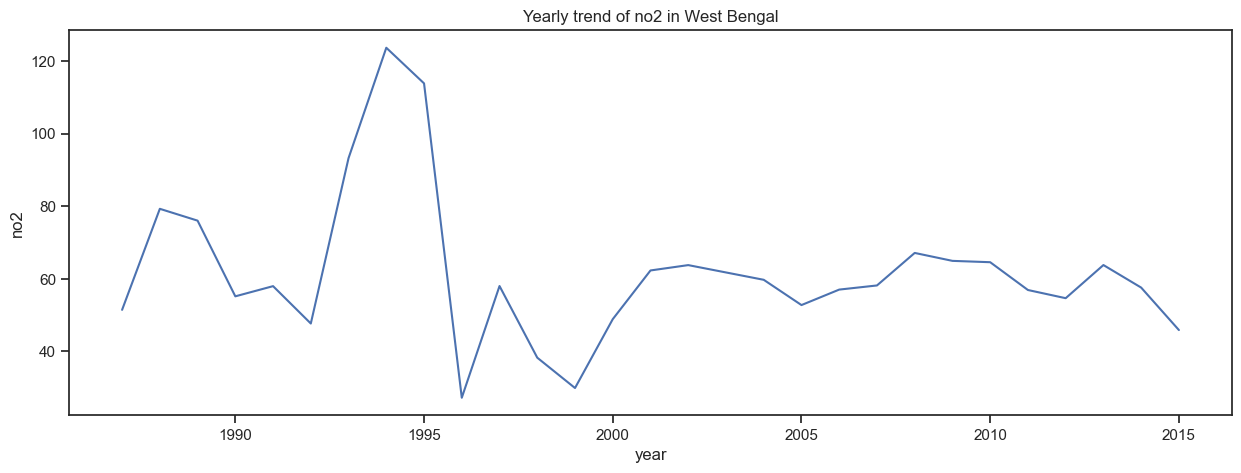

In [48]:
# Cell 8: Yearly Trend for Pollutants
def yearly_trend(state_name="", indicator="so2"):
    plt.figure(figsize=(15, 5))
    aqi['year'] = aqi['date'].dt.year
    if state_name:
        yearly_data = aqi[aqi['state'] == state_name].groupby(['year'])[indicator].mean().reset_index()
        sns.lineplot(x='year', y=indicator, data=yearly_data)
        plt.title(f"Yearly trend of {indicator} in {state_name}")
    else:
        yearly_data = aqi.groupby(['year'])[indicator].mean().reset_index()
        sns.lineplot(x='year', y=indicator, data=yearly_data)
        plt.title(f"Yearly trend of {indicator}")

yearly_trend()
yearly_trend("West Bengal", "no2")

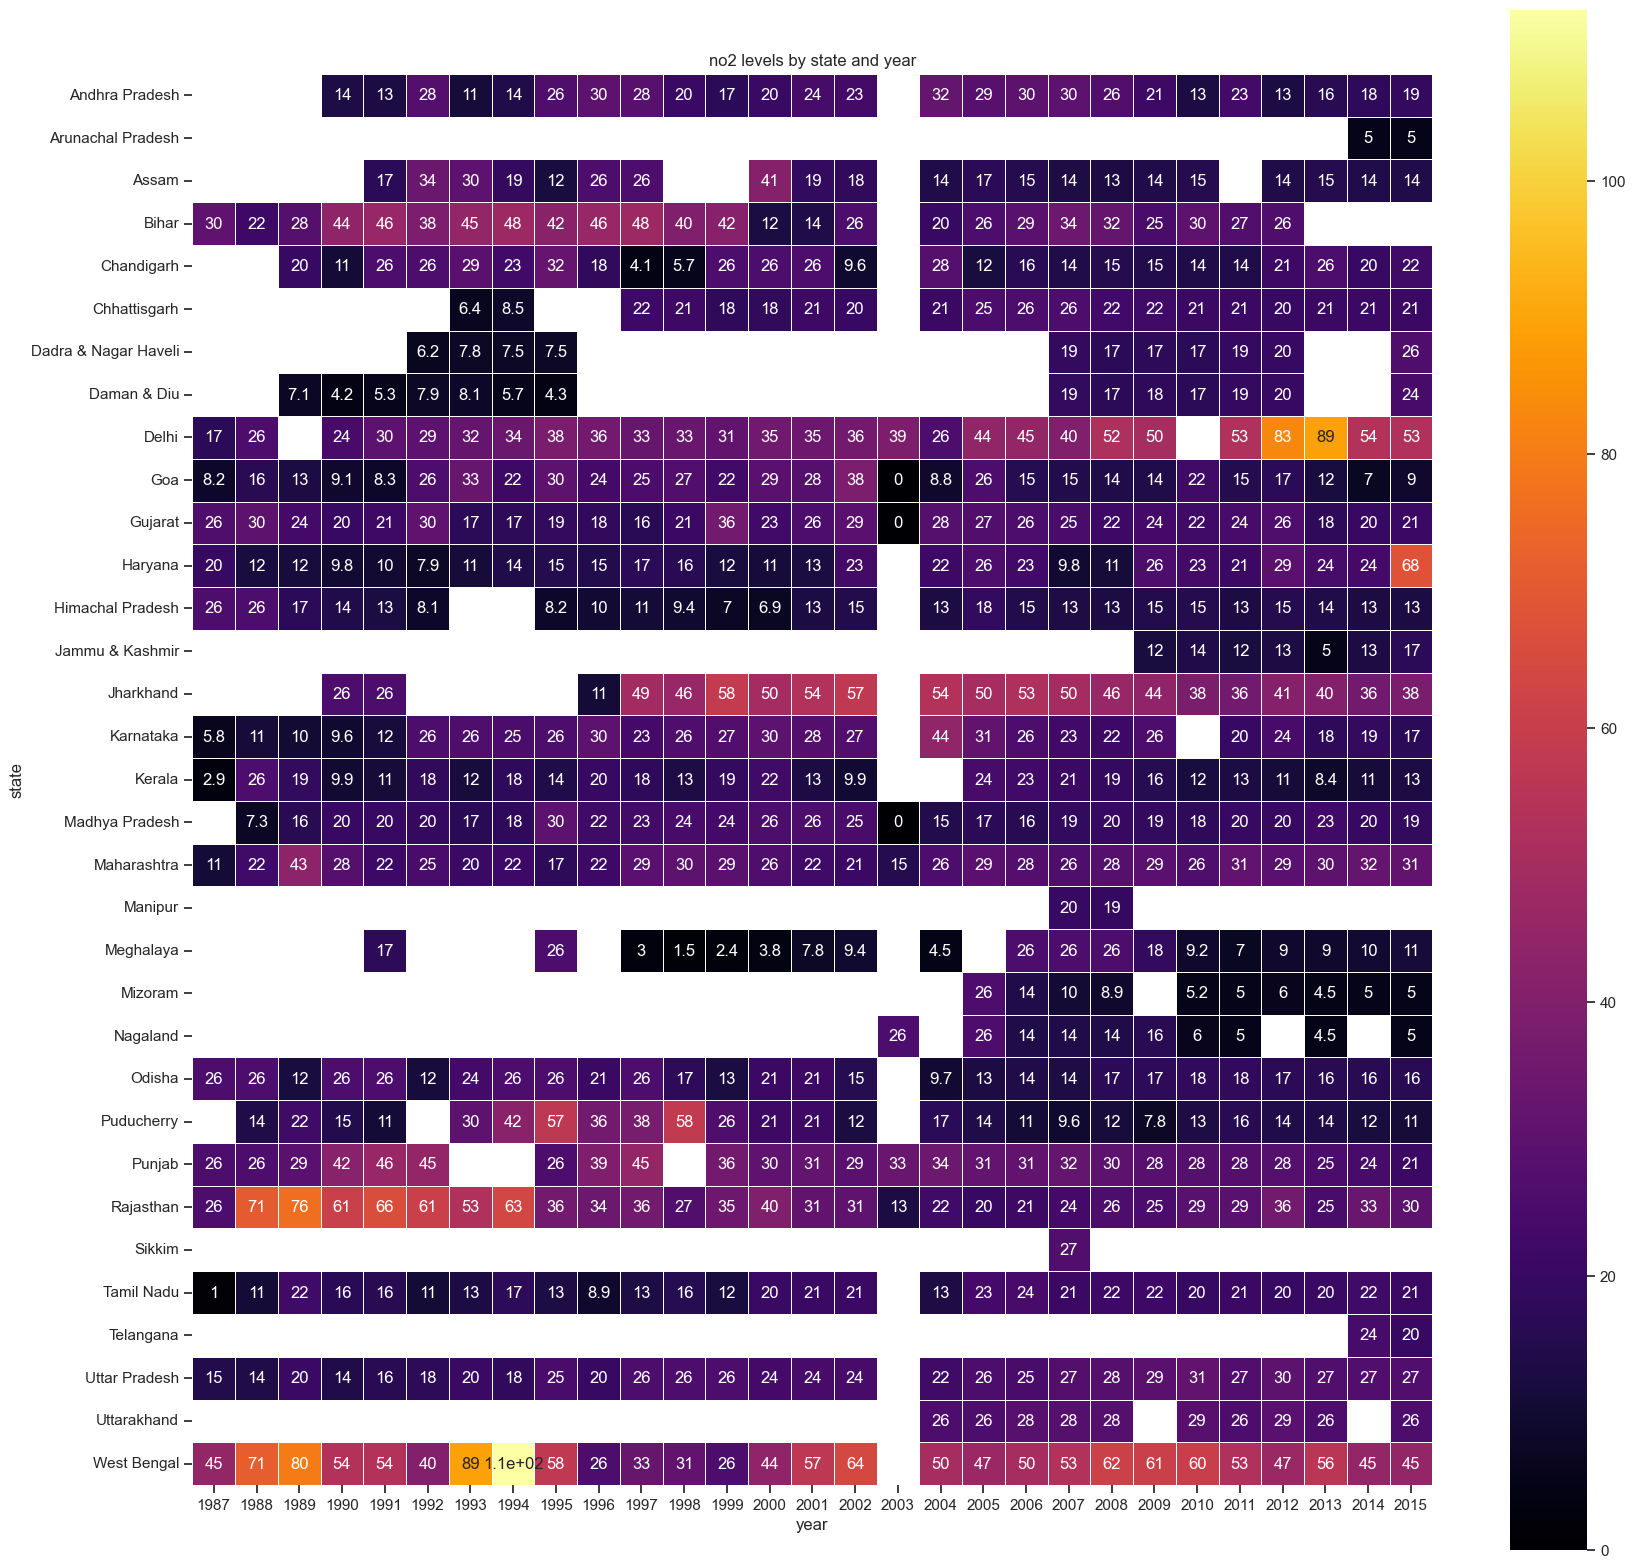

In [49]:
# Cell 9: Heatmap of Yearly Averages by State
def indicator_by_state_and_year(indicator="so2"):
    plt.figure(figsize=(20, 20))
    heatmap_data = aqi.pivot_table(values=indicator, index='state', columns='year', aggfunc='median')
    sns.heatmap(heatmap_data, annot=True, linewidths=.5, cbar=True, square=True, cmap='inferno')
    plt.title(f"{indicator} levels by state and year")

indicator_by_state_and_year('no2')


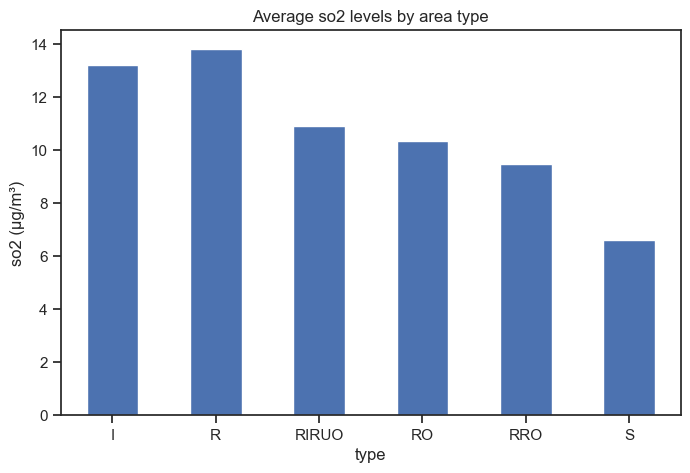

In [53]:
# Cell 10: Pollutant Average by Type
def type_avg(indicator=""):
    type_means = aqi.groupby("type")[VALUE_COLS].mean()
    plt.figure(figsize=(8, 5))
    if indicator:
        type_means[indicator].plot(kind='bar')
        plt.title(f"Average {indicator} levels by area type")
        plt.ylabel(f"{indicator} (µg/m³)")
    else:
        type_means.plot(kind='bar')
        plt.title("Average pollutant levels by area type")
    plt.xticks(rotation=0)

type_avg('so2')


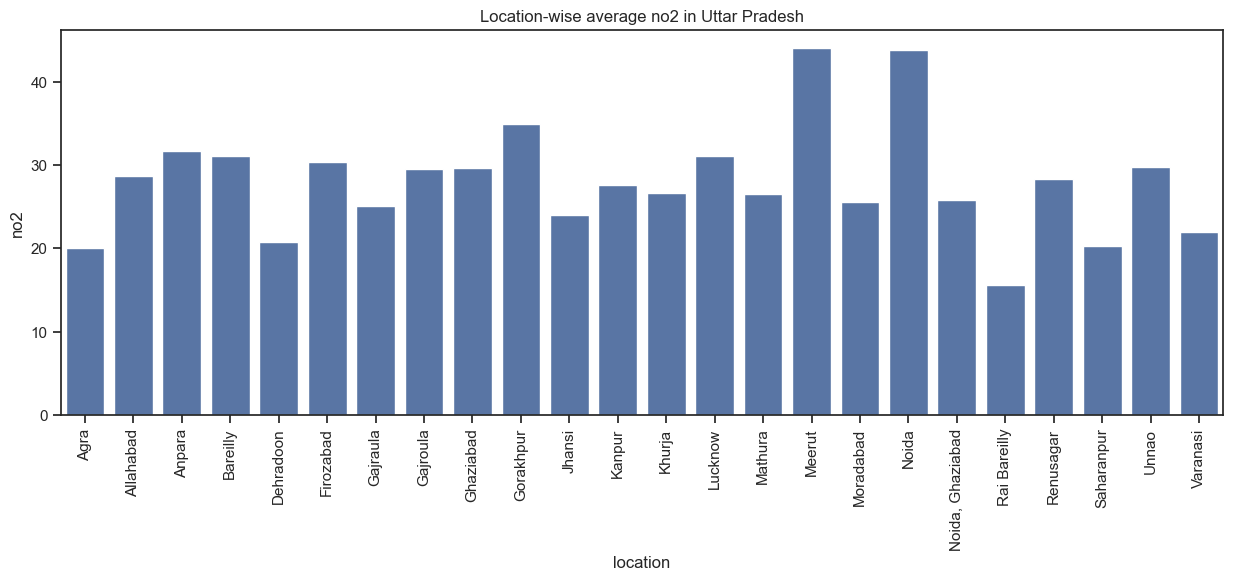

In [51]:
# Cell 11: Location-wise Average for a Given State
def location_avgs(state_name, indicator="so2"):
    state_locs = aqi[aqi['state'] == state_name].groupby(['location'])[indicator].mean().reset_index()
    plt.figure(figsize=(15, 5))
    sns.barplot(x='location', y=indicator, data=state_locs)
    plt.title(f"Location-wise average {indicator} in {state_name}")
    plt.xticks(rotation=90)

location_avgs("Uttar Pradesh", "no2")
